# Finetuning in PyTorch

As deep learning models for images become bigger and more complex, it also becomes more difficult to train them from scratch, i.e. from a randomly initialised "fresh" setup.
In particular, we would need access not only to a very large number of images, but - crucially - we also need typically more than just one powerful GPU to train the network.

Instead, we can quite often use **finetuning**, where we start from a previously trained network, and either use this as the initialistion for our training, or we freeze the pre-trained network apart from the last layer that uses the learned features in the earlier layers for the final classification.
Here, we will use [ResNet 18](https://arxiv.org/abs/1512.03385) which one the first place in the 2015 ILSVRC competition. Although it is not the most modern model, it serves us well here as an example as it performs fairly well and is reasonably small. The [model](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) is downloaded from PyTorch, other models are available at [pretrained models](https://pytorch.org/vision/main/models.html).

In this example, we use the [data](https://download.pytorch.org/tutorial/hymenoptera_data.zip) from the PyTorch Tutorial to adapt a previously trained network to distinguish between bees and ants.

Additionally, we will introduce the the following new concepts:
- Learning-rate scheduler
- data augmentation

Previously, we have used a fixed learning rate for the whole length of the training. However, it may be beneficial to asjust the learning rate as the training progresses. For example, we may want to start with a large learning rate to begin with, and then decrease it as we come nearer to the (local) optimum of the training. The [Optimizer](https://pytorch.org/docs/stable/optim.html) provides a range of options. For example, we can decrease the learning rate every $n$ steps with the [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR),
[exponentially](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR), or others.

Additionally, we use data augmentation to "boost" the effective number of images that are available to us for training. This allows the network to train on variations of the images without having to create images for every conceivable variation. For example, we can crop images so that the ratio of the main object w.r.t. the rest is different, we can rotate or blur images, introduce noise, change the colour or contrast. Applying some augmentations helps us to avoid overtraining and improves the generalisation ability of the network as we increase the variety of image presentations the network sees.
Which augmentations to choose depends on the task at hand, and is part of the model development. The library TorchVison provides a range of [image augmentations](https://pytorch.org/vision/stable/transforms.html) that we will use.

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# learning rate scheduler
from torch.optim import lr_scheduler

from torchvision.models import resnet18, ResNet18_Weights

import torchvision as tv

import matplotlib.pyplot as plt
import numpy as np
import os



In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2023-01-17 08:11:49--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.33.88.59, 13.33.88.36, 13.33.88.85, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.33.88.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  --.-KB/s    in 0.1s    

2023-01-17 08:11:50 (304 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/a

We now define the image transformations and augmentations, and load the data.

For simplicity, we will only use two transformations:
- [Random Crops](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomResizedCrop.html#torchvision.transforms.RandomResizedCrop) that crop a random part of the image and bring it to a certain size afterwards
- [Random Horizontal Flip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) flip the image with a given probability.

We can use the [Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) function to "chain" several steps together.

We will use the pre-trained [Resnet-18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) model.
This model was trained on the [ImageNet](https://www.image-net.org) data, which is a large database containing millions of images. For training of this model, the images were prepared in the following way:
- resizing to ```256x256 pixels```
- cropping aroud the centre with ```254x254 pixels```
- re-scaling all colour values to the interval $[0,1]$
- normalising the values with ```mean=[0.485, 0.456, 0.406]``` and ```nd std=[0.229, 0.224, 0.225]```

Therefore, we also need to process our new images that we want to finetune on using this receipe. For the trainig data, we use ```RandomSizedCrop``` for a random part of the image followed by a flip and then the normalisation is applied, for the test data, we use the images at they are but bring them into the same format as the original training data according to the above receipe.

In [5]:
##
## load images and transform data
##

data_transforms = {
    'train': tv.transforms.Compose([
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': tv.transforms.Compose([
        tv.transforms.Resize(256),
        tv.transforms.CenterCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data/'
batch_size = 4


train_data = tv.datasets.ImageFolder(data_dir +'train',
                                      data_transforms['train'])
test_data  = tv.datasets.ImageFolder(data_dir +'val',
                                      data_transforms['test'])

train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=True)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=True)

##
## extract the class names, i.e. our labels (target)
##
class_names = train_data.classes
print(class_names)

['ants', 'bees']


We can now look at an example image.
Later on, we will use the data loaders to iterate over the images, therfore, we set the same loop up but ```break``` out after one image.

To do so, we first need to transform the image back from the tensor format into the format that we can use to display the image with standard python tools, i.e.
[imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html). PyTorch does provide a convenience function for this [ToPILImage](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToPILImage.html). However, we cannot use this here as we need to "undo" the normalisation of the colour values to see the original image.


Shape of X [N images per batch, # colours, height, width]:  torch.Size([4, 3, 224, 224])
Shape of y:  torch.Size([4]) torch.int64
Shape of image in tensor format torch.Size([3, 224, 224])
Shape of image in normal format (224, 224, 3)
True label: ants


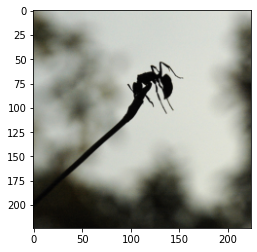

In [7]:
#
# show an example image
#

for X,y in test_loader:
    print("Shape of X [N images per batch, # colours, height, width]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)

    index = 0
    img = X[index]
    print('Shape of image in tensor format {}'.format(img.shape))
    # does the same as ToPILImage but we need to operate on the data
    img = img.numpy().transpose((1, 2, 0))
    print('Shape of image in normal format {}'.format(img.shape))

    # undo normalisation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    print('True label: {}'.format(class_names[y[index]]) )
    break

# Load pretrained model

In this example, we want to start from the pre-trained [Resnet-18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) model that was trained using ImageNet data.

The model and its weights are available through PyTorch. We initialise the model with the default values, i.e. the model trained on the ImageNet data.
We also need to modify the last layer of the model. In our case, we only have two classes we want to distinguish (bees/ants), so we need to replace the final layer that does the classification with with a new layer that only has two classes.
To do so, we first need to determine the number of inputs into the final (fully-connected, i.e. ```fc``` ) layer of the ResNet-18 model, which is derived from [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Rather than looking at the [source](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py), we can use ```in_features``` as the relevant parameter of the network layer.
The corresponding parameter ```out_features``` corresponds to the nubmer of classes in the original ImageNet training, which has 1000 different classes.

We then overwrite the fully connected layer (called ```fc``` in the source code) with our own custom layer. We need the same number of incoming features as we use the rest of the ResNet-18, but then only have two classes.
Rather than hard-coding ```2```, we use ```len(class_names)```.

Finally, we must remember to move the model to the GPU (if we have one)


In [63]:
##
## Load pre-trained model 
##

# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#model = tv.models.inception_v3(pretrained=True)
#model = tv.models.resnet18(pretrained=True)
 
model = tv.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

n_fc_features = model.fc.in_features
print('Number of ingoing features {} and classification nodes {} in original fully connected layer'.format(n_fc_features, model.fc.out_features))

# overwrite fully connected layer
model.fc = nn.Linear(n_fc_features, len(class_names))
print('Number of ingoing features {} and classification nodes {} in new fully connected layer'.format(n_fc_features, model.fc.out_features))

# move to GPU
model = model.to(device)


Using cuda:0 device
Number of ingoing features 512 and classification nodes 1000 in original fully connected layer
Number of ingoing features 512 and classification nodes 2 in new fully connected layer


# Setup training

First, we need to setup the optimizer we want to use, as well as the learn-rate scheduler for the training.
We will use the [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR) learn-rate scheduler here.

We also need to define the loss function, i.e. the metric that we will use to determine how close the predictions are to the true value. Since we work on a classification problem, we will use the [cross-entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).


In [64]:
# Loss function, optimizier, learning rate scheduler
loss_func = nn.CrossEntropyLoss()

# note that all parameters are optimized - no layers are frozen
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Learning rate scheduler
lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



In [65]:
#
# Training loop
#
def train_epoch(dataloader, model, loss_fn, optimizer, lr_schedule):
    size = len(dataloader)
    running_loss = 0.0

    # put the model into training mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # move data to device
        X, y = X.to(device), y.to(device)

        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        #
        # Backpropagation
        #

        # reset gradients
        optimizer.zero_grad()

        # calculate gradient and backward pass, optimisation of weights
        loss.backward()
        optimizer.step()
        


        # record loss functions // change loss -> loss_item ??
        loss_item = loss.item()
        current = batch * len(X)

        running_loss += loss_item
        if batch % 100 == 0:
            #loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

    # adjust step size
    lr_schedule.step()

    return running_loss/size


#
# test loop
#
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # put the model into the evaluation mode.
    model.eval()
    test_loss, correct = 0, 0

    #we don't need gradients for evaluation
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") 
    return correct

In [66]:
epochs = 15
loss_values = []
accuracy_values = []

for t in range(epochs):

    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_epoch(train_loader, model, loss_func, optimizer, lr_schedule)
    loss_values.append(loss)

    accuracy = test(test_loader, model, loss_func)
    accuracy_values.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 0.814752  [    0/   61]
Test Error: 
 Accuracy: 58.8%, Avg loss: 0.708252 

Epoch 2
-------------------------------
loss: 0.342062  [    0/   61]
Test Error: 
 Accuracy: 52.9%, Avg loss: 0.849621 

Epoch 3
-------------------------------
loss: 0.640742  [    0/   61]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.675889 

Epoch 4
-------------------------------
loss: 0.997882  [    0/   61]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.636791 

Epoch 5
-------------------------------
loss: 1.133997  [    0/   61]
Test Error: 
 Accuracy: 59.5%, Avg loss: 1.662653 

Epoch 6
-------------------------------
loss: 0.541383  [    0/   61]
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.606499 

Epoch 7
-------------------------------
loss: 0.761264  [    0/   61]
Test Error: 
 Accuracy: 63.4%, Avg loss: 0.750189 

Epoch 8
-------------------------------
loss: 0.795248  [    0/   61]
Test Error: 
 Accuracy: 62.1%, Avg loss: 0.654480 

Epoch 9
----------------

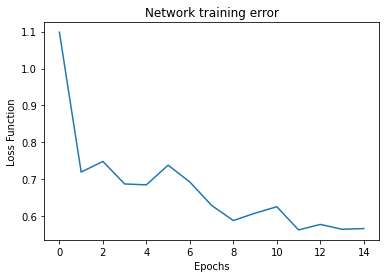

In [67]:
x = range(0, epochs)
plt.plot(x, loss_values, label='training error')
plt.title('Network training error')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.show()

In [71]:
##
## show some images
##
def show_prediction(model, n_image =6):

  images_so_far = 0 

  #put model into evaluation mode
  model.eval()

  fig = plt.figure()

  # switch off gradient tracking
  with torch.no_grad():
    for batch, (X, y) in enumerate(test_loader):
      X, y = X.to(device), y.to(device)
      outputs = model(X)
      _, pred = torch.max(outputs, 1)

      for j in range(X.size()[0]):
        images_so_far += 1
        ax = plt.subplot(n_image//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('pred: {}, true {}'.format(class_names[pred[j]],
                                                class_names[y[j]]))
 
        img = X.cpu().data[j]
        img = img.numpy().transpose((1, 2, 0))

        # undo normalisation
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)


        if images_so_far == n_image: 
          return


True label: bees
True label: bees
True label: bees
True label: bees
True label: bees
True label: ants


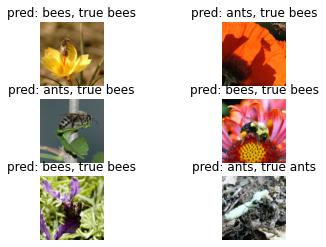

In [72]:
show_prediction(model)